# Lecture 4 Complex Types & Queries

### 1. Learning Objectives

- You will manage unstructured data using JSON and JSONB fields.
- You will query unstructured data in PostgreSQL.
- You will manage complex queries with functions and Common Table Expressions (CTEs).
- You will understand how Views and Materialized views can improve your queries (through the DRY principle or by speeding up execution time).

### 2. Unstructured data

Unstructured data is data that is not suitable for a pre-defined form like a table. For example, the text content of GitHub repository README files. How would you organise this data into a structured tabular format? There are different headers, different lengths, some have images, links, etc.

JSON is probably the most popular way of storing unstructured data and is supported by PostgreSQL.

### 3. `->` and `#>`

**`->`**
> accepts a string (think of this as pandas `.loc`), or an integer (think of this as pandas `.loc`) to index an array

#### Example 1:
```sql
SELECT parsedmd -> 0 FROM throughput.readmejson
LIMIT 5;
```


#### Example 2:
```sql
SELECT parsedmd -> 0 -> 'header' FROM throughput.readmejson
LIMIT 5
```

#### Example 3:
> how many rows have information for the attribute "parsedmd"? (hint: COUNT(col) automatically ignores any entries with null if they exist)
```sql
SELECT COUNT(parsedmd -> 0) FROM throughput.readmejson;
```

---

**`#>`**    
> accepts an array of strings/integers that specify a path to follow through the JSON data (think of this as chaining multiple `.loc`/`.iloc` together).

#### Example 1:

```sql
SELECT parsedmd #> '{0,header}' FROM throughput.readmejson
LIMIT 5
```

#### Example 2:
> 5 most commonly used headers
```sql
SELECT jsonb_array_elements(parsedmd) #> '{level,0}' as level, COUNT(*)
FROM throughput.readmejson
GROUP BY level
ORDER BY count DESC
LIMIT 5;
```

> refresher `jsonb_array_elements`
```sql
SELECT reponame, jsonb_array_elements(parsedmd) FROM throughput.readmejson
LIMIT 10;
```

```sql
```

### 4. CTEs (common table expressions), Views, and Functions. 

> These are all related to streamlining your code and keeping it DRY. As a refresher:

|Object           |Description|SQL command|Documentation|
|-----------------|-----------|---|-------------|
|CTE              |A ***temporary*** result which you can use within other SQL statements.<br>It is not stored and can only be used within a single query.<br>Think of it as a `with` statement in Python.|`WITH`|[Docs](https://www.postgresql.org/docs/9.1/queries-with.html)|
|View             |Essentially a named query that can be used in other queries.<br>Gets re-run every time you reference it, no data is stored on disk.<br>Persists after your session has ended.|`CREATE VIEW`|[Docs](https://www.postgresql.org/docs/9.2/sql-createview.html)|
|Temporary View   |Same as above but automatically dropped after the session ends.|`CREATE TEMP VIEW`|[Docs](https://www.postgresql.org/docs/9.2/sql-createview.html)|
|Materialized View|Physically stores the query result on disc for faster access.<br>Needs to be refreshed if the source data changes.<br>Persists after your session has ended.|`CREATE MATERIALIZED VIEW`|[Docs](https://www.postgresql.org/docs/current/sql-creatematerializedview.html)|
|Functions        |Just like functions in R or Python.<br>Reusable code that can accept arguments.|`CREATE FUNCTION`|[Docs](https://www.postgresql.org/docs/9.1/sql-createfunction.html)|

#### 1). CTE

#### Example: 
> What's the most common word starting with a captial letter used in level 1 headers in `readmejson` and how often does it appear?

> Hint: The PostgreSQL regex for words with a captial letter is: `\y[A-Z].*?\y` . To answer this question, I used a subquery and some grouping (`GROUP BY`) and filtering (`WHERE`) in combination with some functions like `string_to_array()` and `jsonb_array_elements()`.


**approach 1:**
```sql
SELECT words, count(*) FROM (
	SELECT TRIM(UNNEST(string_to_array(header, ' '))) AS words FROM (
		SELECT jsonb_array_elements(parsedmd) #>> '{level,0}' as level, jsonb_array_elements(parsedmd) #>> '{header,0}' as header
		FROM throughput.readmejson
	) AS headers
	WHERE level = '1' 
) AS words
WHERE words ~ '\y[A-Z].*?\y'
GROUP BY words
ORDER BY count DESC
LIMIT 1

```

**approach 2:**
```sql
WITH headers_data AS (
	SELECT jsonb_array_elements(parsedmd) #>> '{level,0}' as level, jsonb_array_elements(parsedmd) #>> '{header,0}' as header
	FROM throughput.readmejson
)
, words_data AS (
	SELECT TRIM(UNNEST(string_to_array(header, ' '))) as word FROM headers_data
	WHERE level = '1'
)
SELECT word, COUNT(*) FROM words_data
WHERE word ~ '^\y[A-Z].*?\y'
GROUP BY word
ORDER BY count DESC
LIMIT 1
```

**approach 3:**

```sql
WITH word_data AS (
	SELECT jsonb_array_elements(parsedmd) #>> '{level,0}' as level, TRIM(UNNEST(string_to_array(jsonb_array_elements(parsedmd) #>> '{header,0}', ' '))) as word
	FROM throughput.readmejson
)
SELECT word, COUNT(*) FROM word_data
WHERE level = '1'
AND word ~ '^\y[A-Z].*?\y'
GROUP BY word
ORDER BY count DESC
LIMIT 1

```

#### 2). Views

#### Example:
> combine `repoid`, `reponame`, `markdown`
```sql
CREATE VIEW throughput.readmemd AS (
	WITH reponame_md AS (
		SELECT reponame, regexp_replace(markdown, '\[([^\[\]]+)\]\(([^)]+\))|(=)|(\\n)|(#)|(\\r)|(-)', '', 'g') as markdown
		FROM throughput.readmejson
	), repoid_reponame AS (
		SELECT DISTINCT
			repos.repoid,
			owners.owner || '/' || repos.repo as reponame
		FROM throughput.repos
		JOIN throughput.repoowner
		ON repos.repoid = repoowner.repoid
		JOIN throughput.owners
		ON repoowner.ownerid = owners.ownerid	
	)
	SELECT DISTINCT repoid, reponame_md.reponame, markdown 
	FROM reponame_md
	JOIN repoid_reponame
	ON repoid_reponame.reponame = reponame_md.reponame
)
```

#### 3). Functions

#### Example: 
> Create a function called `get_readmemd()` that returns a table of `reponame`s and `markdown` for repositories that use a particular language (e.g., Python or R). You can specify a table as the returned data like this: `RETURNS TABLE(reponame text, markdown text)`. Your function should work like this (your returned data may differ to mine based on how PostgreSQL retrieves your data):


```sql
CREATE FUNCTION throughput.get_readmemd(lang character varying)
    RETURNS TABLE(reponame text, markdown text)
    LANGUAGE SQL
AS $$
	SELECT DISTINCT reponame, markdown 
	FROM throughput.readmemd
	JOIN throughput.repolang
	ON readmemd.repoid = repolang.repoid
	WHERE language ILIKE(lang)
$$;
```


> Usage

```sql
SELECT * FROM throughput.get_readmemd('Python')
```

# Lecture 5: Indexing

### 1. Learning Objectives
- You will understand the different types of INDEXes available in Postgres and the best suited applications.
- You will be able to profile and optimize various queries to provide the fastest response.
- You will be able to create INDEXes in PostgreSQL.

### 2. Summary

### 1). High-level overview
- [Efficient Use of PostgreSQL Indexes | Heroku Dev Center](https://devcenter.heroku.com/articles/postgresql-indexes#index-types)

### 2). what is indexing?
- An index is a way to efficiently retrieve a relatively small number of rows from a table. It is only useful if the number of rows to be retrieved from a table is relatively small (i.e. the condition for retrieving rows - the WHERE clause - is selective). B-Tree indexes are also useful for avoiding sorting.
- Storage/time tradeoffs
Wile an index helps us find and retrieve rows faster, it also adds some overhead to the database: it takes time to make and uses up disk space.

### 3). Why indexing?
- allow database to read less data from disk (though indexes are stored in disk too!)
- read blocks of adjacent data more efficiently from disk 


### 4). Indexing technique

#### [B-tree](https://mp.weixin.qq.com/s/rDCEFzoKHIjyHfI_bsz5Rw)
- best for range search; also good for equality search

####  [Hashing](https://www.mssqltips.com/sqlservertip/3099/understanding-sql-server-memoryoptimized-tables-hash-indexes/#:~:text=What%20is%20a%20hash%20index,bucket%20of%20the%20hash%20index.)
- check equality only
- only good when column is of low cardinality (the column has low number of unique values)

#### GIST (Generalized Search Tree)
- for indexing multi-dimensional information such as geographical coordinates, spatial object i.e. 
   - Rectangular box ((x1,y1),(x2,y2))
   - path [(x1,y1),…]
   - circle <(x,y),r>
- Supports many search types, including spatial and full text.
- Can be extended to custom data types
- Balanced tree-based method (nodes & leaves)

#### GIN (Generalized Inverted Tree)

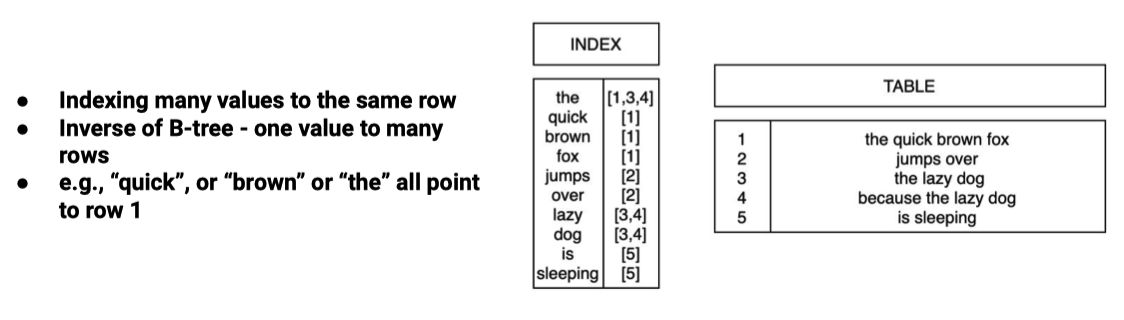



#### BRIN (Block Range Index)

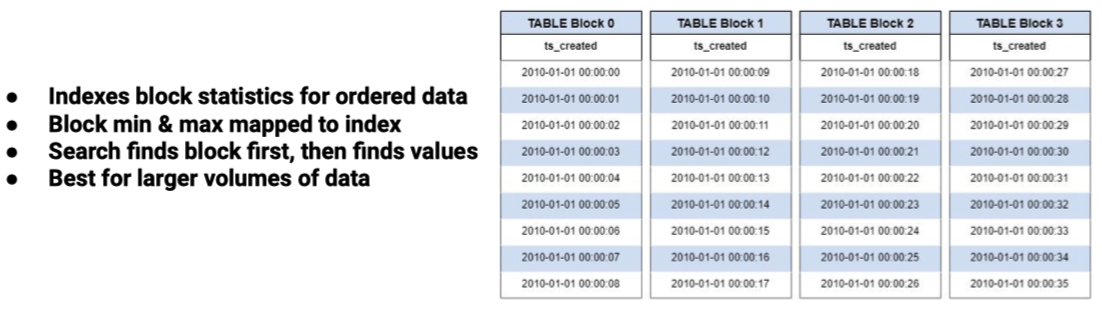


### 3. SQL code


#### 1). Create Index 

```sql
CREATE INDEX tweet_idx ON public.tweets (tweet);

CREATE INDEX date_idx ON public.tweets (date);
```

#### 2). [Multi-column Indexes](https://devcenter.heroku.com/articles/postgresql-indexes#multi-column-indexes)
```sql
CREATE INDEX tweet_date_idx ON public.tweets (tweet, date);
```

#### 3). Check the space that the index takes

```sql
SELECT pg_size_pretty(pg_table_size('index_name')) as size;
```

#### 4). Check performance and if a query uses index
```sql
EXPLAIN ANALYZE
SELECT * FROM users
JOIN tweets
ON users.userid = tweets.userid
WHERE tweet = '💡'
AND date BETWEEN '2020-11-10 12:00:00' and '2020-11-10 13:00:00';
```

#### 5). Drop Index/tables 
```sql
DROP TABLE IF EXISTS tweets CASCADE;
DROP TABLE IF EXISTS users CASCAD
DROP INDEX IF EXISTS tweet_index;
DROP INDEX IF EXISTS date_index;
DROP INDEX IF EXISTS tweet_date_index;
```

# Lecture 6: Working with Public Data

### 1. Learning Objectives

- You will understand the difficulties and considerations of working with public data.
- You will be able to construct queries that answer specific questions related to the data.
- You will be able to optimize the data structures within the database to reflect the queries you've implemented.

# Lecture 7: 

### 1. Learning Objectives

- Based on a defined research question you will be able to define key entities.
- You will understand how and entity relationship diagram can help with modeling problems and analytic workflows.
- You will be able to show relevant relationships and identify data sources that may suit elements of the data model.
- You will understand similarities and differences among database types (e.g., relational databases, graph databases, data warehouses, etc.)

### 2. Database Development Lifecycle (Simplified)

<center>
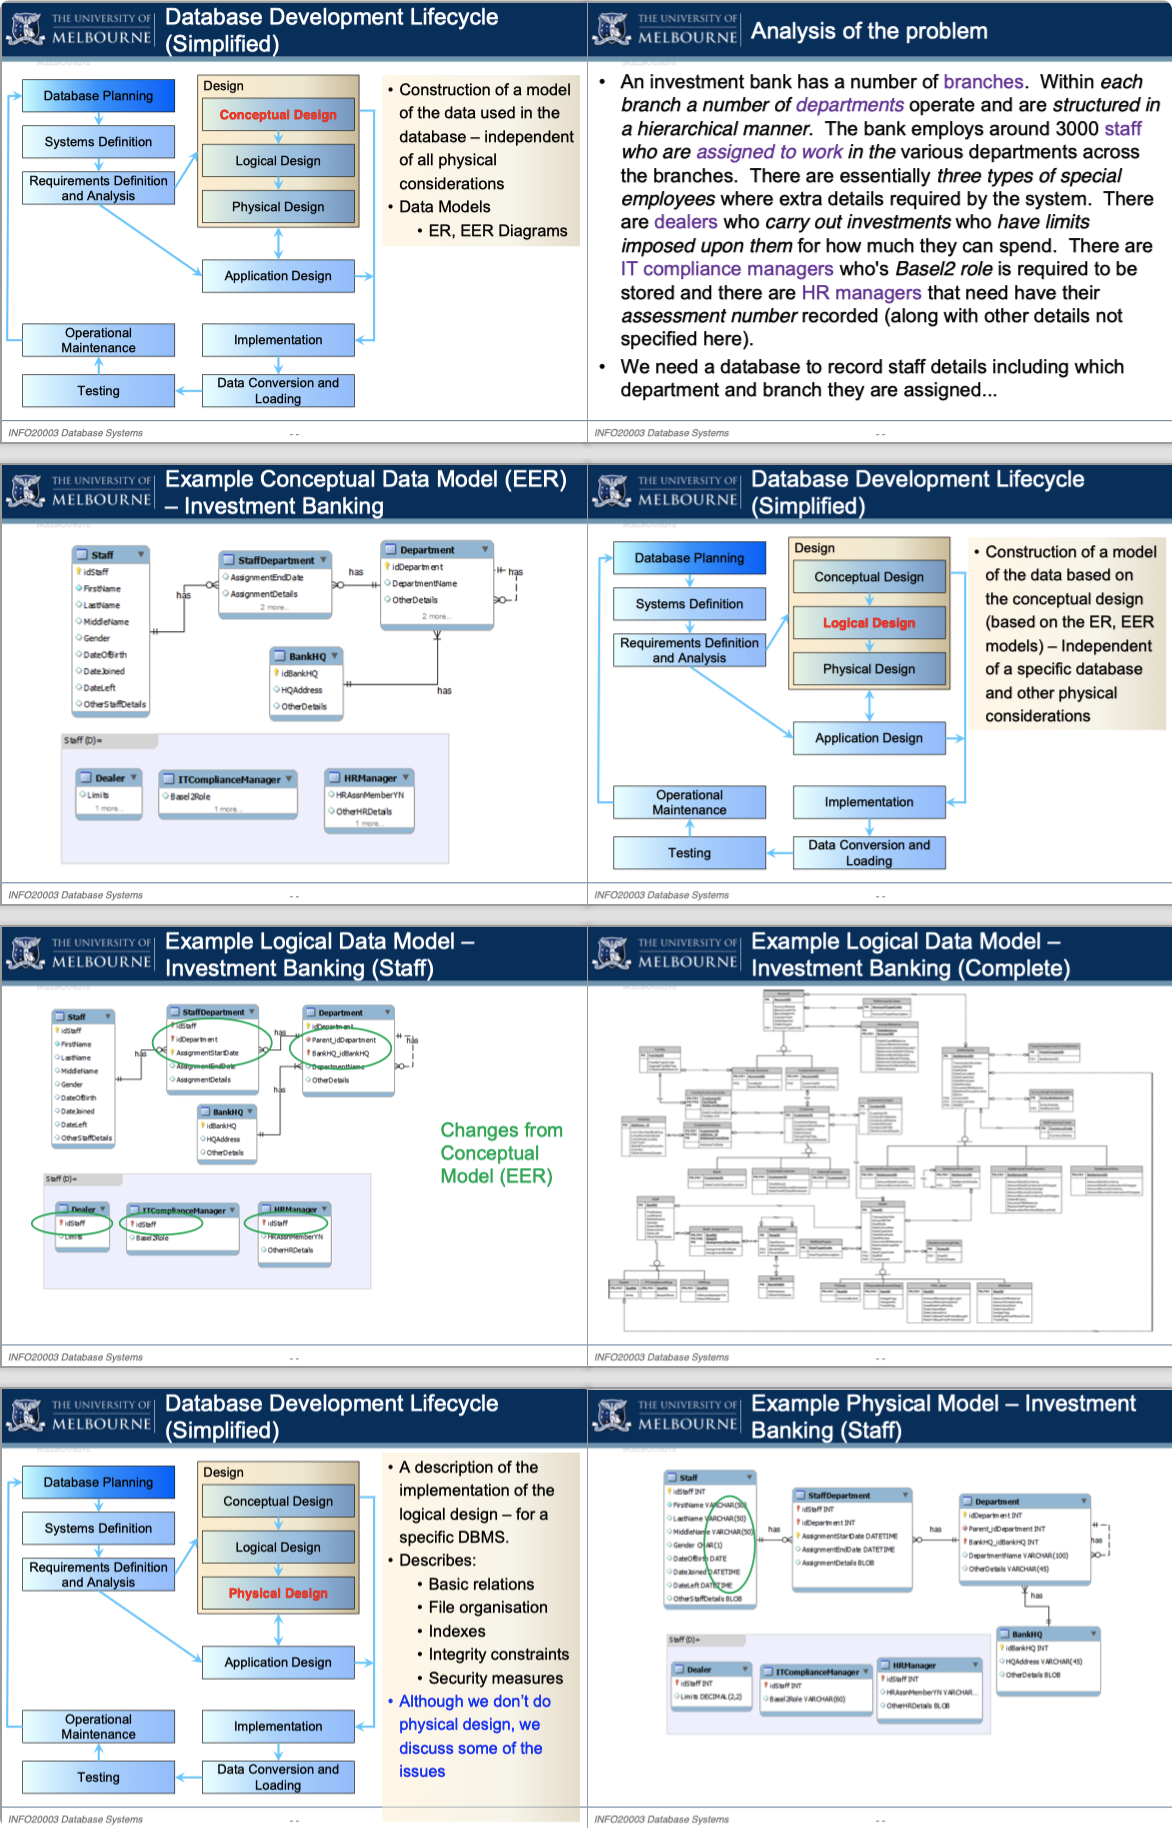
    </center>


### 3. Entity Relationships

See INFO20003 slides - Lecture 5.


### 4. database types 


#### 1). relational database (INFO20003 Lecture 22)    
- In the **relational database** objects are defined as entities Relationships are defined in tables.
> - relational databases design goals
>    - Reduce Redundancy
>    - Reduce Incompleteness 
>    - Generalize the Solution

#### 2). NoSQL databases (INFO20003 Lecture 20)
- Key-value store
- document database
- Column wide
- graph databases       
relationships defined the data (searches by relationships).

#### 3). data warehouses


# Lecture 8:

## 1. Learning Objectives

- You will understand how database management systems can be optimized for big data applications
- You will understand how the axes of big data (the 5Vs) apply to databases

### 2. Summary
> how database management systems can be optimized for big data applications    
> [Source - The System Design Primer](https://github.com/donnemartin/system-design-primer#database)

#### 1). Document store

- partition -> map-reduce


#### 2). Distributed file system (HADOOP)
- NOT for speed, but just for storage

#### 3). Sharding/[Partition](https://www.wikiwand.com/en/Partition_(database))

- Vertical sharding
> tables (or columns within tables) are split among nodes

- Horizontal sharding
> rows within table are split.

<center>
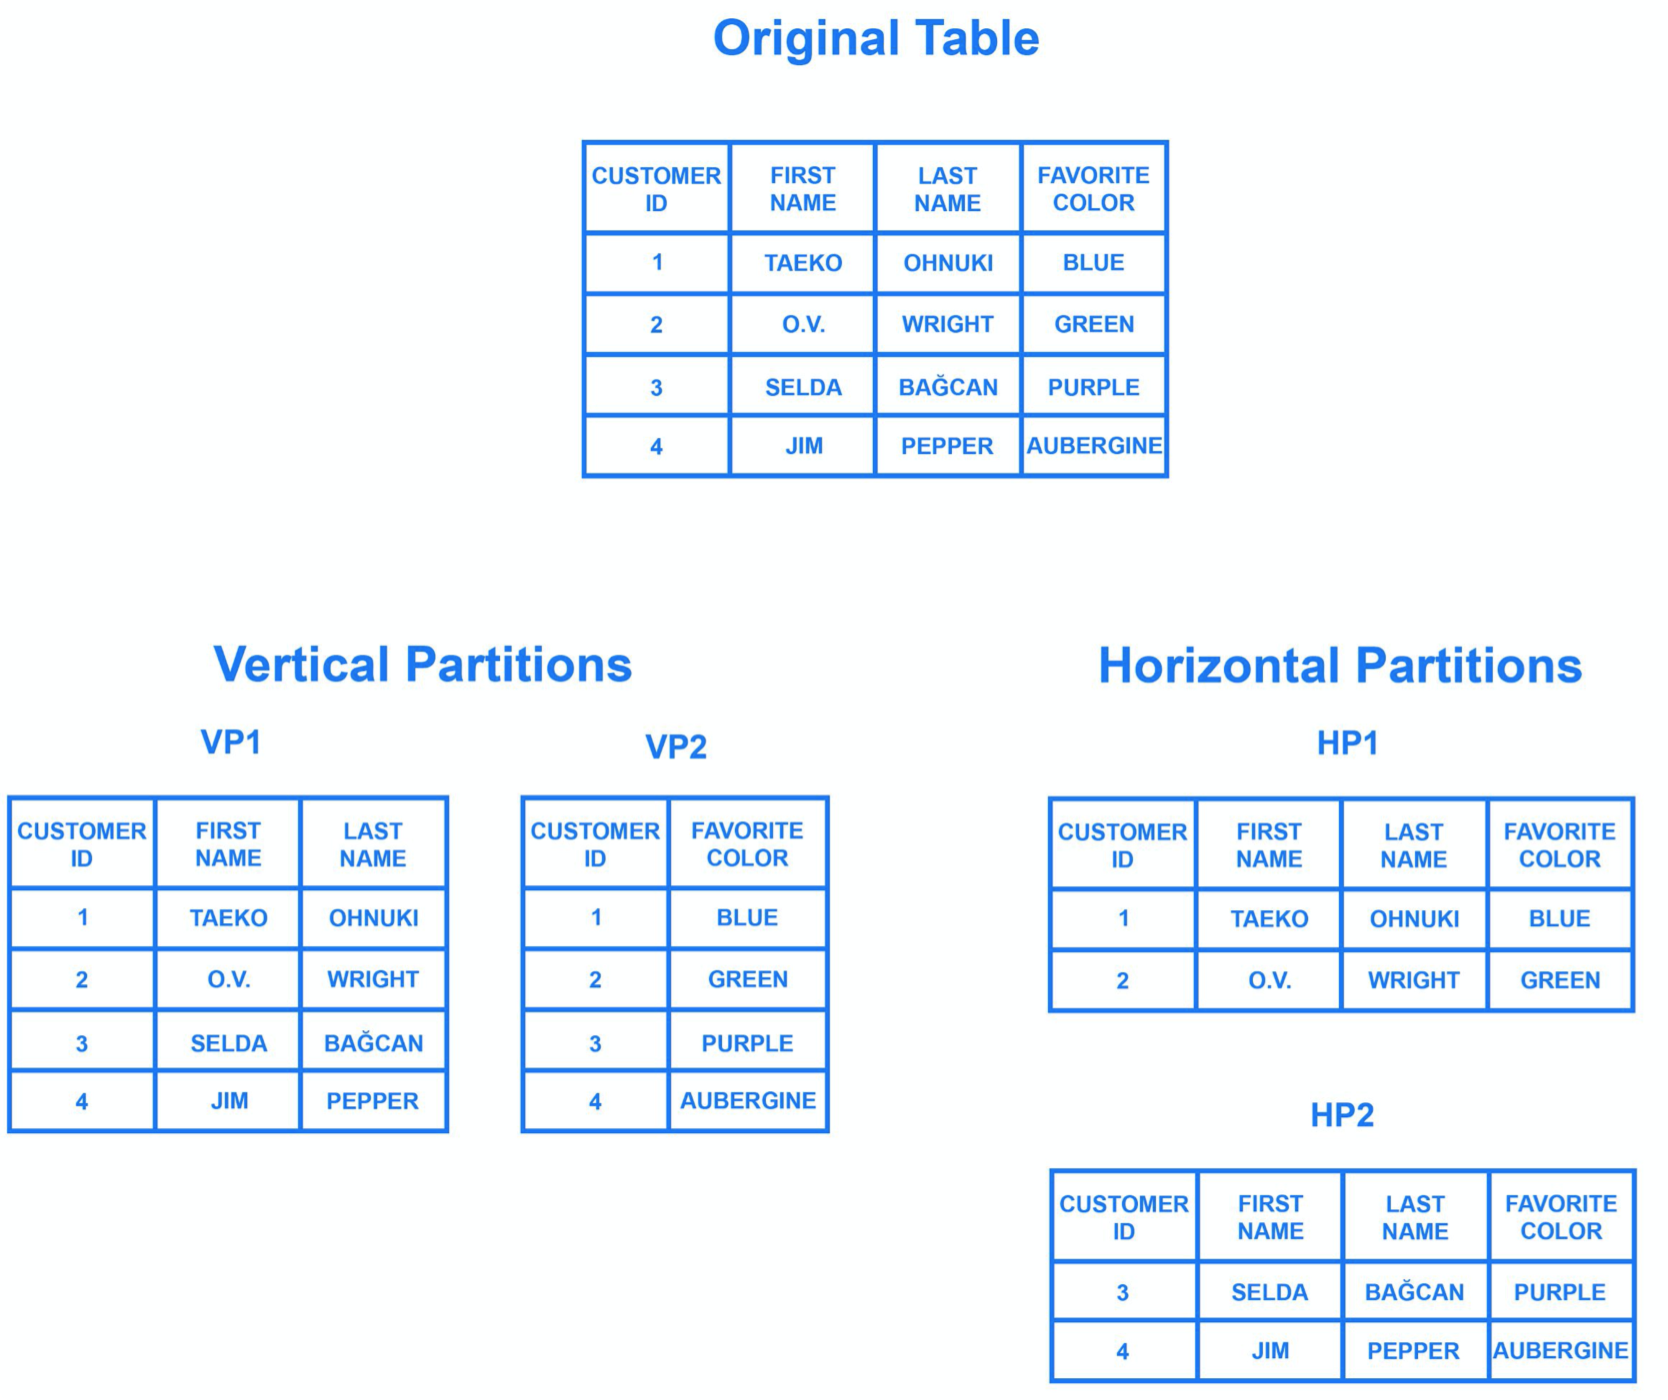
    </center>

